In [1]:
# импортируем необходимые библиотеки
import numpy as np
import pandas as pd

In [2]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('Data/Bankloan.csv', 
                   encoding='cp1251', 
                   sep=';', decimal=',')

In [3]:
# выводим первые 5 наблюдений датафрейма
data.head()

,age,job,employ,address,income,debtinc,creddebt,othdebt,default
0,28,working - other,7,2,44,17.7,2.990592,4.797408,0
1,64,working - production,34,17,116,14.7,5.047392,12.004608,0
2,40,working - IT,20,12,61,4.8,1.042368,1.885632,0
3,30,working - IT,11,3,27,34.5,1.751220,7.563780,0
4,25,working - IT,2,2,30,22.4,0.759360,5.960640,1


In [4]:
# смотрим типы переменных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
age         1500 non-null int64
job         1500 non-null object
employ      1500 non-null int64
address     1500 non-null int64
income      1500 non-null int64
debtinc     1500 non-null float64
creddebt    1500 non-null float64
othdebt     1500 non-null float64
default     1500 non-null int64
dtypes: float64(3), int64(5), object(1)
memory usage: 105.5+ KB


In [5]:
# создаем массив меток
label = data.pop('default')

## Случайное разбиение на обучающую и тестовую выборки

In [6]:
# импортируем из модуля sklearn.model_selection 
# функцию train_test_split()
from sklearn.model_selection import train_test_split
# выполняем разбиение на обучающую и тестовую выборки
X_tr, X_tst, y_tr, y_tst = train_test_split(data, label, 
                                            test_size=0.3, 
                                            random_state=42)
# выполняем дамми-кодирование
X_tr = pd.get_dummies(X_tr)
X_tst = pd.get_dummies(X_tst)

In [7]:
# импортируем класс DecisionTreeClassifier 
from sklearn.tree import DecisionTreeClassifier
# создаем экземпляр класса DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=152)
# обучаем модель
tree.fit(X_tr, y_tr)
# оцениваем качество модели на тестовых данных
print('Правильность на тестовой выборке: {:.3f}'.format(
    tree.score(X_tst, y_tst)))

Правильность на тестовой выборке: 0.647


## Обычная k-блочная перекрестная проверка

In [8]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('Data/Bankloan.csv', 
                   encoding='cp1251', 
                   sep=';', decimal=',')

# создаем массив меток и массив признаков
y = data.pop('default')
X = pd.get_dummies(data)

# импортируем функцию cross_val_score(), классы KFold и StratifiedKFold
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
# создаем экземпляр класса KFold
nonstrat = KFold(n_splits=10, shuffle=True, 
                 random_state=42)
# создаем экземляр класса DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=152)
# вычисляем значение правильности, усредненное по проверочным
# блокам обычной нестратифицированной перекрестной проверки
scores_acc_tr = cross_val_score(tree, 
                                X, 
                                y, 
                                cv=nonstrat)
print('Среднее значение правильности: {:.2f}'.format(
    scores_acc_tr.mean()))

Среднее значение правильности: 0.68


In [9]:
# создаем экземпляр класса StratifiedKFold
strat = StratifiedKFold(n_splits=10, shuffle=True, 
                        random_state=42)
# вычисляем значение правильности, усредненное по проверочным
# блокам обычной стратифицированной перекрестной проверки
scores_acc_tr = cross_val_score(tree, 
                                X, 
                                y, 
                                cv=strat)
print('Среднее значение правильности: {:.2f}'.format(
    scores_acc_tr.mean()))

Среднее значение правильности: 0.68


In [10]:
# вычисляем значение AUC, усредненное по проверочным 
# блокам обычной стратифицированной перекрестной проверки
scores_auc_tr = cross_val_score(tree, 
                                X, 
                                y, 
                                scoring='roc_auc', 
                                cv=strat)
print('Среднее значение AUC: {:.2f}'.format(
    scores_auc_tr.mean()))

Среднее значение AUC: 0.65


In [11]:
# импортируем библиотеку matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# импортируем функции roc_curve(), auc() и interp()
from sklearn.metrics import roc_curve, auc
from scipy import interp

In [12]:
# пишем функцию, которая отрисовывает ROC-кривые
# и вычисляет AUC для проверочных блоков
# перекрестной проверки
def crossValPlot(skf, classifier, X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    
    f,ax = plt.subplots(figsize=(10,7))
    i = 0
    for train, test in skf.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # вычисляем AUC
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='AUC блок %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Случайное угадывание', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Усредненное значение AUC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 станд. отклонение.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('1 - специфичность')
    ax.set_ylabel('Чувствительность')
    ax.set_title('ROC-кривая для проверочных блоков перекрестной проверки')
    ax.legend(bbox_to_anchor=(1,1))

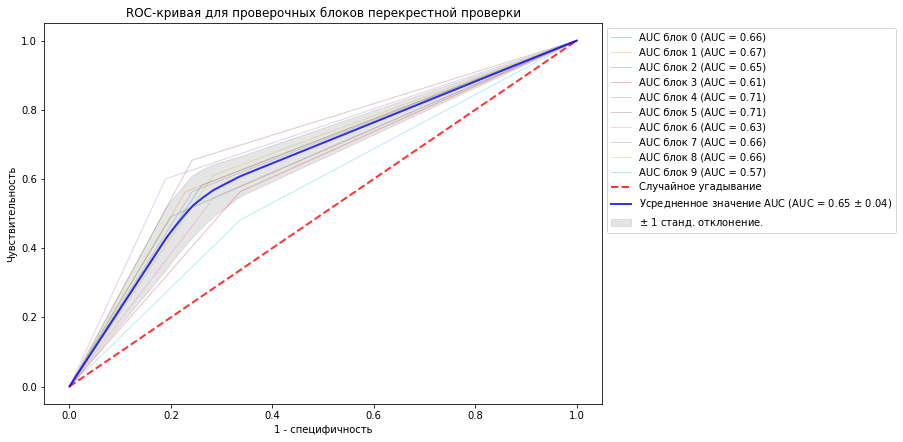

In [13]:
# строим график
crossValPlot(strat, tree, X, y)

## Повторная k-блочная перекрестная проверка

In [14]:
# импортируем классы RepeatedKFold и RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold
# создаем экземпляр класса RepeatedKFold
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)
# вычисляем значение правильности, усредненное по
# проверочным блокам повторной нестратифицированной
# перекрестной проверки
scores_acc_tr = cross_val_score(tree, 
                                X, 
                                y, 
                                cv=rkf)
print('Среднее значение правильности: {:.2f}'.format(
    scores_acc_tr.mean()))

Среднее значение правильности: 0.68


In [15]:
# создаем экземпляр класса RepeatedStratifiedKFold
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=42)
# вычисляем значение правильности, усредненное по
# проверочным блокам повторной стратифицированной
# перекрестной проверки
scores_acc_tr = cross_val_score(tree, 
                                X, 
                                y, 
                                cv=rskf)
print('Среднее значение правильности: {:.2f}'.format(
    scores_acc_tr.mean()))

Среднее значение правильности: 0.68


## k-кратное случайное разбиение на обучающую и тестовую выборки (перекрестная проверка Монте-Карло)

In [16]:
# загружаем данные
montecarlo = pd.read_csv('Data/Bankloan.csv', 
                         encoding='cp1251', 
                         sep=';', decimal=',')

# сформируем массив меток
y_montecarlo = montecarlo.pop('default')

In [17]:
# пишем функцию, выполняющую перекрестную проверку
# по методу Монте-Карло
def monte_carlo_crossvalidation(X, y, n_split, test_size):
    # создадим пустой список, в которой будем
    # записывать значения правильности
    accuracy_list = []
    # выполняем n_split раз случайное разбиение на обучающую 
    # и тестовую выборки (размер тестовой выборки определяется 
    # с помощью test_size) и печатаем значение правильности 
    # для обучающей и тестовой выборок в каждой итерации
    for i in range(n_split):
        train, test, y_train, y_test = train_test_split(X, 
                                                        y,
                                                        random_state=i,
                                                        test_size=test_size)
        train = pd.get_dummies(train)
        test = pd.get_dummies(test)
        print('train=%d, test=%d' % (len(train), len(test)))
        tree.fit(train, y_train)
        train_score = tree.score(train, y_train)
        test_score = tree.score(test, y_test)
        print('Правильность на обучающей выборке: {:.3f}'.format(train_score))
        print('Правильность на тестовой выборке: {:.3f}'.format(test_score))
        print('')
        accuracy_list.append(test_score)
    # печатаем среднее значение правильности
    print('Среднее значение правильности: {:.3f}'.format(
        sum(accuracy_list) / len(accuracy_list)))

In [18]:
# применяем нашу функцию
monte_carlo_crossvalidation(montecarlo, y_montecarlo, n_split=10, test_size=0.3)

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.667

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.738

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.689

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.662

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.640

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.669

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.700

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.676

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильность на тестовой выборке: 0.693

train=1050, test=450
Правильность на обучающей выборке: 1.000
Правильност

## Перекрестная проверка с исключением по одному

In [19]:
# импортируем класс LeaveOneOut
from sklearn.model_selection import LeaveOneOut
# создаем экземпляр класса LeaveOneOut 
loo = LeaveOneOut()
# вычисляем значение правильности, усредненное по проверочным
# блокам перекрестной проверки c исключением по одному
scores_acc_tr = cross_val_score(tree, 
                                X, 
                                y, 
                                cv=loo)
print('Количество итераций cv: ', len(scores_acc_tr))
print('Среднее значение правильности: {:.2f}'.format(
    scores_acc_tr.mean()))

Количество итераций cv:  1500
Среднее значение правильности: 0.67


## Перекрестная проверка с разбиением на блоки-группы

In [20]:
# импортируем класс GroupKFold
from sklearn.model_selection import GroupKFold
# создаем массив признаков и массив меток
X_gr = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y_gr = [5.7, 5.3, 5.6, 6.4, 6.1, 6.0, 9.6, 9.8, 9.3, 9.5]
# создаем идентификатор групп
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]
# создаем экземпляр класса GroupKFold 
gkf = GroupKFold(n_splits=3)
# взглянем на индексы наблюдений, попавших в обучающие
# блоки и проверочный блок, по каждой из 3 итераций
for train, test in gkf.split(X_gr, y_gr, groups=groups):
     print('TRAIN', train, 'TEST', test)

TRAIN [0 1 2 3 4 5] TEST [6 7 8 9]
TRAIN [0 1 2 6 7 8 9] TEST [3 4 5]
TRAIN [3 4 5 6 7 8 9] TEST [0 1 2]


## Комбинированная проверка в ручном режиме

In [21]:
# импортируем функцию train_test_split()
from sklearn.model_selection import train_test_split
# импортируем функцию roc_auc_score()
from sklearn.metrics import roc_auc_score
# создаем обучающий и тестовый массивы признаков и меток
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, random_state=42)
# создаем экземпляр класса StratifiedKFold, 5-блочную
# перекрестную проверку со случайным перемешиванием данных
strat = StratifiedKFold(n_splits=5, shufﬂe=True, random_state=42)
best_score = 0
for max_depth in [4, 6, 8, 10]:
    for max_features in [3, 6, 9, 12]:
        # для каждой из 16 комбинаций значений гиперпараметров создаем экземпляр
        # класса DecisionTreeClassifier - модель дерева CART
        tree = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features,  
                                      random_state=42)
        # для каждой из 16 комбинаций значений гиперпараметров будем строить 5 моделей дерева 
        # CART (5 раз на 4 обучающих блоках перекрестной проверки будем строить модель,
        # на 1 контрольном блоке - проверять, вычисляя AUC)
        scores = cross_val_score(tree, X_train, y_train, scoring='roc_auc', cv=strat)
        # для каждой из 16 комбинаций значений гиперпараметров вычисляем значение AUC, 
        # усредненное по 5 контрольным блокам перекрестной проверки 
        auc_score = np.mean(scores)
        # если получаем максимальное усредненное значение AUC, 
        # сохраняем его и комбинацию значений гиперпараметров
        if auc_score > best_score:
            best_score = auc_score
            best_parameters = {'max_features': max_features, 'max_depth': max_depth}
# строим модель с комбинацией значений гиперпараметров, давшей максимальное 
# усредненное значение AUC, на обучающей выборке
tree_best = DecisionTreeClassifier(**best_parameters, random_state=42)
tree_best.fit(X_train, y_train)
# проверяем качество модели с комбинацией значений гиперпараметров, 
# давшей максимальное усредненное значение AUC, на тестовой выборке
test_score = roc_auc_score(y_test, tree_best.predict_proba(X_test)[:, 1])
print('Наилучшие значения гиперпараметров: ', best_parameters)
print('Лучшее усредненное значение AUC cv: {:.2f}'.format(best_score))
print('AUC модели с наилучшими значениями гиперпараметров на тестовой выборке: {:.2f}'.format(test_score))

Наилучшие значения гиперпараметров:  {'max_features': 9, 'max_depth': 4}
Лучшее усредненное значение AUC cv: 0.79
AUC модели с наилучшими значениями гиперпараметров на тестовой выборке: 0.78


## Комбинированная проверка с помощью класса GridSearchCV

In [22]:
# создаем экземпляр класса DecisionTreeClassifier
tree_grid = DecisionTreeClassifier(random_state=42)
# импортируем класс GridSearchCV
from sklearn.model_selection import GridSearchCV
# задаем сетку параметров, будем перебирать разные значения штрафа
param_grid = {'max_depth': [4, 6, 8, 10], 
              'max_features': [3, 6, 9, 12]}
# создаем экземпляр класса GridSearchCV
grid_search = GridSearchCV(tree_grid, 
                           param_grid, 
                           scoring='roc_auc', 
                           return_train_score=True,
                           n_jobs=-1, cv=strat)
# запускаем решетчатый поиск
grid_search.fit(X_train, y_train)
# проверяем качество модели с комбинацией значений гиперпараметров, 
# давшей максимальное усредненное значение AUC, на тестовой выборке
test_score = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:, 1])
# смотрим результаты решетчатого поиска
print('Наилучшие значения гиперпараметров: {}'.format(grid_search.best_params_))
print('Лучшее усредненное значение AUC cv: {:.2f}'.format(grid_search.best_score_))
print('AUC модели с наилучшими значениями гиперпараметров на тестовой выборке: {:.2f}'.format(test_score))

Наилучшие значения гиперпараметров: {'max_depth': 4, 'max_features': 9}
Лучшее усредненное значение AUC cv: 0.79
AUC модели с наилучшими значениями гиперпараметров на тестовой выборке: 0.78


## Вложенная перекрестная проверка

In [23]:
# импортируем класс GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

# задаем сетку гиперпараметров
grid = {'max_depth': [2, 3, 4], 'max_features': [2, 3, 4]}

scores = cross_val_score(GridSearchCV(GradientBoostingClassifier(random_state=42), 
                                      grid, cv=StratifiedKFold(n_splits=5)),
                         X, y, cv=StratifiedKFold(n_splits=5))
print('Значения правильности: ', scores)
print('Среднее значение правильности: ', scores.mean())

Значения правильности:  [0.74418605 0.76079734 0.77333333 0.77926421 0.72575251]
Среднее значение правильности:  0.7566666888891358


In [24]:
# пишем функцию, выполняющую вложенную
# перекрестную проверку
def nested_cv(X, y, inner_cv, outer_cv, Classifier, parameter_grid):
    # преобразовываем в массивы Numpy
    X = X.values
    y = y.values
    # собираем значения правильности по всем внешним разбиениям    
    outer_scores = []
    # для каждого разбиения данных во внешней перекрестной проверке
    # (метод split возвращает индексы)
    for training_samples, test_samples in outer_cv.split(X, y):
        # находим наилучшие значения гиперпараметров с помощью внутренней перекрестной проверки
        best_params = {}
        best_score = -np.inf
        # итерируем по гиперпараметрам
        for parameters in parameter_grid:
            # собираем значения правильности по всем внутренним разбиениям
            cv_scores = []
            # итерируем по разбиениям внутренней перекрестной проверки 
            for inner_train, inner_test in inner_cv.split(
                X[training_samples], y[training_samples]):
                # строим классификатор с данными значениями гиперпараметров на внутренних обучающих блоках
                clf = Classifier(**parameters, solver='liblinear')
                clf.fit(X[inner_train], y[inner_train])
                # оцениваем качество на внутреннем тестовом наборе
                score = clf.score(X[inner_test], y[inner_test])
                # добавляем в cv_scores
                cv_scores.append(score)
            # вычисляем среднее значение правильности по внутренним проверочным блокам
            mean_score = np.mean(cv_scores)
            if mean_score > best_score:
                # если лучше, чем предыдущие, запоминаем 
                # наилучшие значения гиперпараметров
                best_score = mean_score
                best_params = parameters
        # строим классификатор с наилучшими значениями гиперпараметров на внешних обучающих блоках
        clf = Classifier(**best_params, solver='liblinear')
        clf.fit(X[training_samples], y[training_samples])
        # оцениваем качество на внешнем тестовом блоке
        out_score = clf.score(X[test_samples], y[test_samples])
        # печатаем наилучшие значения гиперпараметров и значение правильности
        print(best_params, out_score)
        # добавляем в outer_scores
        outer_scores.append(out_score)
    return np.array(outer_scores)

In [25]:
# импортируем класс LogisticRegression
from sklearn.linear_model import LogisticRegression

# задаем сетку гиперпараметров
logreg_grid = {'C': [0.01, 0.05, 0.1, 0.25, 0.5, 1]}

# каждое значение гиперпараметра или каждую комбинацию значений 
# гиперпараметров выделяем в словарь
from sklearn.model_selection import ParameterGrid
# применяем нашу функцию
scores = nested_cv(X, 
                   y, 
                   StratifiedKFold(n_splits=5), 
                   StratifiedKFold(n_splits=5), 
                   LogisticRegression, 
                   ParameterGrid(logreg_grid))

{'C': 0.05} 0.7242524916943521
{'C': 0.01} 0.7674418604651163
{'C': 0.01} 0.7766666666666666
{'C': 0.5} 0.8127090301003345
{'C': 0.01} 0.7324414715719063


In [26]:
print('Среднее значение правильности: ', scores.mean())

Среднее значение правильности:  0.7627023040996752


## Разбиение на обучающую и тестовую выборки, учитывающее временную структуру данных

In [27]:
# записываем CSV-файл в объект DataFrame
timeseries_data = pd.read_csv('Data/Flats.csv', 
                              encoding='UTF-8', 
                              sep=';', 
                              decimal=',')

In [28]:
# выводим первые 5 наблюдений датафрейма
timeseries_data.head()

,Rooms_Number,Street,House_Number,Metro_m,Stor,Storeys,Wall,Space_Total,Value_abs,Date_Create
0,1,Оловозаводская,12/1,6340,1,6,Кирпич,32.5,1450000,22.08.2016
1,1,Оловозаводская,12/1,6340,2,6,Кирпич,33.8,1650000,30.01.2017
2,1,Оловозаводская,12/1,6340,6,6,Кирпич,37.2,2250000,28.10.2014
3,1,Оловозаводская,12/1,6340,6,6,Кирпич,36.4,1960000,19.08.2014
4,1,Оловозаводская,12/1,6340,2,6,Кирпич,35.3,1950000,28.02.2014


In [29]:
# преобразовываем в формат даты
timeseries_data['Date_Create'] = pd.to_datetime(timeseries_data['Date_Create'], 
                                                format='%d.%m.%Y')

In [30]:
# сортируем данные по дате сделки
# (от самой ранней к самой поздней)
timeseries_data = timeseries_data.sort_values(by='Date_Create', 
                                              ascending=1)
timeseries_data

,Rooms_Number,Street,House_Number,Metro_m,Stor,Storeys,Wall,Space_Total,Value_abs,Date_Create
11,2,Сухарная,76/3,3730,7,10,Кирпич,57.20,3300000,2005-07-06
5,1,Оловозаводская,12/1,6340,2,6,Кирпич,34.00,1700000,2011-11-23
12,3,Сухарная,76/3,3730,5,15,Кирпич,76.30,4950000,2013-12-06
16,3,Народная,16/1,3210,1,5,Панель,58.00,2900000,2014-01-30
4,1,Оловозаводская,12/1,6340,2,6,Кирпич,35.30,1950000,2014-02-28
9,2,Сухарная,76/3,3730,14,15,Кирпич,57.10,3850000,2014-04-17
3,1,Оловозаводская,12/1,6340,6,6,Кирпич,36.40,1960000,2014-08-19
2,1,Оловозаводская,12/1,6340,6,6,Кирпич,37.20,2250000,2014-10-28
18,2,Чкалова,70/1,4390,4,9,Кирпич,47.00,3100000,2014-12-01
10,3,Сухарная,76/3,3730,13,15,Кирпич,74.20,5450000,2015-02-11


In [31]:
# выполняем разбиение на обучающую и тестовую выборки, 
# учитывающее временную структуру
X_time_tr, X_time_tst, y_time_tr, y_time_tst = train_test_split(timeseries_data.drop('Value_abs', axis=1), 
                                                                timeseries_data['Value_abs'], 
                                                                test_size=.3, 
                                                                shuffle=False)

In [32]:
# смотрим обучающую выборку
X_time_tr

,Rooms_Number,Street,House_Number,Metro_m,Stor,Storeys,Wall,Space_Total,Date_Create
11,2,Сухарная,76/3,3730,7,10,Кирпич,57.2,2005-07-06
5,1,Оловозаводская,12/1,6340,2,6,Кирпич,34.0,2011-11-23
12,3,Сухарная,76/3,3730,5,15,Кирпич,76.3,2013-12-06
16,3,Народная,16/1,3210,1,5,Панель,58.0,2014-01-30
4,1,Оловозаводская,12/1,6340,2,6,Кирпич,35.3,2014-02-28
9,2,Сухарная,76/3,3730,14,15,Кирпич,57.1,2014-04-17
3,1,Оловозаводская,12/1,6340,6,6,Кирпич,36.4,2014-08-19
2,1,Оловозаводская,12/1,6340,6,6,Кирпич,37.2,2014-10-28
18,2,Чкалова,70/1,4390,4,9,Кирпич,47.0,2014-12-01
10,3,Сухарная,76/3,3730,13,15,Кирпич,74.2,2015-02-11


In [33]:
# смотрим тестовую выборку
X_time_tst

,Rooms_Number,Street,House_Number,Metro_m,Stor,Storeys,Wall,Space_Total,Date_Create
15,2,Народная,16/1,3210,1,5,Панель,44.40,2017-01-30
1,1,Оловозаводская,12/1,6340,2,6,Кирпич,33.80,2017-01-30
7,1,Шатурская,4,19820,17,17,Кирпич,35.27,2017-02-15
14,1,Сухарная,76/3,3730,13,15,Кирпич,37.10,2017-12-06
17,2,Чкалова,70/1,4390,1,9,Кирпич,52.00,2018-02-21
8,1,Планировочная,37,0,5,10,NaN,33.00,2018-08-30


In [34]:
# записываем CSV-файл в объект DataFrame
wellsfargo_data = pd.read_csv('Data/wellsfargo.csv', sep=';')
# выводим первые 5 наблюдений
wellsfargo_data.head()

,date,count_1,count_2,count_3,count_4,amount_1,amount_2,amount_3,count_5,count_6,count_7,amount_4,type,response
0,04.03.2017,1,1,0,0,10.0,10.0,0.0,1,0.0,1,10.0,O,0
1,21.10.2016,1,1,0,0,1000.0,1000.0,0.0,1,0.0,1,1000.0,O,0
2,28.12.2016,3,1,1,1,1000.0,1000.0,0.0,1,0.0,3,1000.0,O,0
3,08.01.2017,2,2,6,0,1000.0,1000.0,0.0,1,0.0,1,400.0,O,1
4,27.11.2017,1,1,0,0,1000.0,1000.0,0.0,1,0.0,1,1000.0,O,0


In [35]:
# преобразовываем в формат даты
wellsfargo_data['date'] = pd.to_datetime(wellsfargo_data['date'])

In [36]:
# сортируем данные по дате
# (от самой ранней к самой поздней)
wellsfargo_data = wellsfargo_data.sort_values(by='date', 
                                              ascending=1)

In [37]:
# удаляем на месте date
wellsfargo_data.drop('date', inplace=True, axis=1)

In [38]:
# выполняем разбиение на обучающую и тестовую выборки, учитывающее временную структуру
X_wellsfargo_train, X_wellsfargo_test, y_wellsfargo_train, y_wellsfargo_test = train_test_split(
    wellsfargo_data.drop('response', axis=1), wellsfargo_data['response'], 
    test_size=0.3, shuffle=False)

In [39]:
# выполняем дамми-кодирование
X_wellsfargo_train = pd.get_dummies(X_wellsfargo_train)
X_wellsfargo_test = pd.get_dummies(X_wellsfargo_test)

In [40]:
# создаем экземляр класса GradientBoostingClassifier
boost = GradientBoostingClassifier(random_state=152)
# обучаем модель
boost.fit(X_wellsfargo_train, y_wellsfargo_train)
# оцениваем качество модели на обучающих данных
print('AUC на обучающей выборке: {:.3f}'.format(
    roc_auc_score(y_wellsfargo_train, boost.predict_proba(X_wellsfargo_train)[:, 1])))
# оцениваем качество модели на тестовых данных
print('AUC на тестовой выборке: {:.3f}'.format(
    roc_auc_score(y_wellsfargo_test, boost.predict_proba(X_wellsfargo_test)[:, 1])))

AUC на обучающей выборке: 0.899
AUC на тестовой выборке: 0.845


## Перекрестная проверка, учитывающая временную структуру данных

In [41]:
# импортируем класс TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
# создаем экземпляр класса TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)
# создаем массив меток и массив признаков
y_timeseries = timeseries_data.pop('Value_abs').values
X_timeseries = timeseries_data.values

In [42]:
# взглянем на индексы наблюдений, попавших в обучающий
# и тестовый наборы, по каждой из 3 итераций
for train_index, test_index in tscv.split(X_timeseries):
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X_timeseries[train_index], X_timeseries[test_index]
    y_train, y_test = y_timeseries[train_index], X_timeseries[test_index]
    print('Общее кол-во наблюдений: %d' % (len(X_train) + len(X_test)))
    print('Обучающий набор: %d' % (len(X_train)))
    print('Тестовый набор: %d' % (len(X_test)))
    print('')

TRAIN: [0 1 2 3 4] TEST: [5 6 7 8 9]
Общее кол-во наблюдений: 10
Обучающий набор: 5
Тестовый набор: 5

TRAIN: [0 1 2 3 4 5 6 7 8 9] TEST: [10 11 12 13 14]
Общее кол-во наблюдений: 15
Обучающий набор: 10
Тестовый набор: 5

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] TEST: [15 16 17 18 19]
Общее кол-во наблюдений: 20
Обучающий набор: 15
Тестовый набор: 5



In [43]:
# фиксируем размер обучающего набора
tscv2 = TimeSeriesSplit(n_splits=3, max_train_size=5)

In [44]:
# взглянем на индексы наблюдений, попавших в обучающий
# и тестовый наборы, по каждой из 3 итераций
for train_index, test_index in tscv2.split(X_timeseries):
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X_timeseries[train_index], X_timeseries[test_index]
    y_train, y_test = y_timeseries[train_index], y_timeseries[test_index]
    print('Общее кол-во наблюдений: %d' % (len(X_train) + len(X_test)))
    print('Обучающий набор: %d' % (len(X_train)))
    print('Тестовый набор: %d' % (len(X_test)))
    print('')

TRAIN: [0 1 2 3 4] TEST: [5 6 7 8 9]
Общее кол-во наблюдений: 10
Обучающий набор: 5
Тестовый набор: 5

TRAIN: [5 6 7 8 9] TEST: [10 11 12 13 14]
Общее кол-во наблюдений: 10
Обучающий набор: 5
Тестовый набор: 5

TRAIN: [10 11 12 13 14] TEST: [15 16 17 18 19]
Общее кол-во наблюдений: 10
Обучающий набор: 5
Тестовый набор: 5



In [45]:
# создаем массив меток и массив признаков
y_wellsfargo = wellsfargo_data.pop('response').values
X_wellsfargo = pd.get_dummies(wellsfargo_data).values

In [46]:
# создаем экземпляр класса TimeSeriesSplit,
# перекрестная проверка расширяющимся окном
time_cv = TimeSeriesSplit(n_splits=3)

In [47]:
# взглянем на индексы наблюдений, попавших в обучающий
# и тестовый наборы, по каждой из 3 итераций, а также
# посмотрим правильность на разных временных срезах
for train_index, test_index in time_cv.split(X_wellsfargo):
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train, X_test = X_wellsfargo[train_index], X_wellsfargo[test_index]
    y_train, y_test = y_wellsfargo[train_index], y_wellsfargo[test_index]
    print('Общее кол-во наблюдений: %d' % (len(X_train) + len(X_test)))
    print('Обучающий набор: %d' % (len(X_train)))
    print('Тестовый набор: %d' % (len(X_test)))
    boost.fit(X_train, y_train)
    print('AUC на обучающей выборке: {:.3f}'.format(
        roc_auc_score(y_train, boost.predict_proba(X_train)[:, 1])))
    print('AUC на тестовой выборке: {:.3f}'.format(
        roc_auc_score(y_test, boost.predict_proba(X_test)[:, 1])))
    print('')

TRAIN: [   0    1    2 ... 1247 1248 1249] TEST: [1250 1251 1252 ... 2497 2498 2499]
Общее кол-во наблюдений: 2500
Обучающий набор: 1250
Тестовый набор: 1250
AUC на обучающей выборке: 0.935
AUC на тестовой выборке: 0.835

TRAIN: [   0    1    2 ... 2497 2498 2499] TEST: [2500 2501 2502 ... 3747 3748 3749]
Общее кол-во наблюдений: 3750
Обучающий набор: 2500
Тестовый набор: 1250
AUC на обучающей выборке: 0.904
AUC на тестовой выборке: 0.854

TRAIN: [   0    1    2 ... 3747 3748 3749] TEST: [3750 3751 3752 ... 4997 4998 4999]
Общее кол-во наблюдений: 5000
Обучающий набор: 3750
Тестовый набор: 1250
AUC на обучающей выборке: 0.898
AUC на тестовой выборке: 0.844



In [48]:
# создаем экземпляр класса TimeSeriesSplit,
# перекрестная проверка скользящим окном
time_cv2 = TimeSeriesSplit(n_splits=3, max_train_size=1250)

In [49]:
# взглянем на индексы наблюдений, попавших в обучающий
# и тестовый наборы, по каждой из 3 итераций, а также
# посмотрим правильность на разных временных срезах
for train_index, test_index in time_cv2.split(X_wellsfargo):
    print('TRAIN:', train_index[0], train_index[-1], 'TEST:', test_index[0], test_index[-1])
    X_train, X_test = X_wellsfargo[train_index], X_wellsfargo[test_index]
    y_train, y_test = y_wellsfargo[train_index], y_wellsfargo[test_index]
    print('Общее кол-во наблюдений: %d' % (len(X_train) + len(X_test)))
    print('Обучающий набор: %d' % (len(X_train)))
    print('Тестовый набор: %d' % (len(X_test)))
    boost.fit(X_train, y_train)
    print('AUC на обучающей выборке: {:.3f}'.format(
        roc_auc_score(y_train, boost.predict_proba(X_train)[:, 1])))
    print('AUC на тестовой выборке: {:.3f}'.format(
        roc_auc_score(y_test, boost.predict_proba(X_test)[:, 1])))
    print('')

TRAIN: 0 1249 TEST: 1250 2499
Общее кол-во наблюдений: 2500
Обучающий набор: 1250
Тестовый набор: 1250
AUC на обучающей выборке: 0.935
AUC на тестовой выборке: 0.835

TRAIN: 1250 2499 TEST: 2500 3749
Общее кол-во наблюдений: 2500
Обучающий набор: 1250
Тестовый набор: 1250
AUC на обучающей выборке: 0.947
AUC на тестовой выборке: 0.852

TRAIN: 2500 3749 TEST: 3750 4999
Общее кол-во наблюдений: 2500
Обучающий набор: 1250
Тестовый набор: 1250
AUC на обучающей выборке: 0.948
AUC на тестовой выборке: 0.830



## Бутстреп

In [50]:
# импортируем необходимые функции
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
# конкатенируем массив признаков и массив меток
data = pd.concat([X, y], axis=1)
# преобразовываем датафрейм в массив NumPy
values = data.values
# задаем количество итераций
n_iterations = 100
n_size = int(len(data) * 0.50)
# создаем список, в котором будем 
# хранить значения правильности
acc_stats = list()
# создаем список, в котором будем 
# хранить значения AUC
auc_stats = list()
# запускаем бутстреп
for i in range(n_iterations):
    # подготавливаем обучающий и тестовый наборы
    train = resample(values, n_samples=n_size)
    test = np.array([x for x in values if x.tolist() not in train.tolist()])
    # обучаем модель дерева
    model = DecisionTreeClassifier(random_state=152)
    model.fit(train[:,:-1], train[:,-1])
    # оцениваем правильность модели
    predictions = model.predict(test[:,:-1])
    acc_score = accuracy_score(test[:,-1], predictions)
    acc_stats.append(acc_score)
    # оцениваем AUC модели
    probabilities = model.predict_proba(test[:,:-1])[:, 1]
    auc_score = roc_auc_score(test[:,-1], probabilities)
    auc_stats.append(auc_score)
# печатаем среднее значение правильности
print("Среднее значение правильности: {:.2f}".format(np.mean(acc_stats)))
# печатаем среднее значение AUC
print("Среднее значение AUC: {:.2f}".format(np.mean(auc_stats)))

Среднее значение правильности: 0.67
Среднее значение AUC: 0.65


## Доверительный интервал

### Асимптотический метод

#### Учимся вычислять асимптотический 90%-ный доверительный интервал среднего

In [51]:
# импортируем модуль random
import random
# задаем стартовое значение
# генератора случайных чисел
random.seed(444)
# генеририруем 50 случайных чисел
# в диапазоне от 45 до 100
income = np.random.uniform(45, 100, size=(50,))

In [52]:
# вычисляем среднее значение дохода
mean_income = np.mean(income)
mean_income

74.58633052300175

In [53]:
# записываем информацию о размере выборки
N = 50

In [54]:
# вычисляем предел погрешности 
err = 1.645 * (np.std(income) / np.sqrt(N))

In [55]:
# вычисляем нижнюю границу 90%-ного
# доверительного интервала 
mean_income - err

71.04773556807402

In [56]:
# вычисляем верхнюю границу 90%-ного
# доверительного интервала 
mean_income + err

78.12492547792948

### Бутстреп-метод

#### Учимся вычислять бутстрепированный 95%-ный доверительный интервал среднего

In [57]:
# импортируем модуль stats
from scipy import stats

# пишем функцию, извлекающую бутстреп-выборки
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

# пишем функцию, вычисляющую нижнюю и верхнюю границы доверительного 
# интервала для полученного распределения оценок
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# пишем итоговую функцию, в которой объединяем первые две
def bootstrap_conf_int(data, stat_func, alpha=0.05, n_samples=1000):
    ''' 
    a = np.random.normal(size=1000)
    conf_int(a, np.median)
    '''
    scores = [stat_func(sample) for sample in get_bootstrap_samples(data, n_samples)]
    return stat_intervals(scores, alpha)

In [58]:
# вычисляем бутстрепированный 95%-ный 
# доверительный интервал среднего
bootstrap_conf_int(income, np.mean, alpha=0.05, n_samples=1000)

array([70.39128329, 78.77699954])

### Доверительный интервал метрики качества (на примере AUC)

#### Учимся вычислять бутстрепированный 95%-ный доверительный интервал AUC и правильности

In [59]:
# вычисляем бутстрепированные доверительные интервалы
# правильности и AUC
alpha = 0.95
# задаем процентиль 2,5
p = ((1.0 - alpha) / 2.0) * 100
# вычисляем нижнюю границу доверительного интервала правильности
lower_acc = max(0.0, np.percentile(acc_stats, p))
# вычисляем нижнюю границу доверительного интервала AUC
lower_auc = max(0.0, np.percentile(auc_stats, p))
# задаем процентиль 97,5
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
# вычисляем верхнюю границу доверительного интервала правильности
upper_acc = min(1.0, np.percentile(acc_stats, p))
# вычисляем верхнюю границу доверительного интервала AUC
upper_auc = min(1.0, np.percentile(auc_stats, p))
# печатаем доверительный интервал правильности
print("%.1f доверительный интервал правильности %.1f%% и %.1f%%" % (
    alpha * 100, lower_acc * 100, upper_acc * 100))
# печатаем доверительный интервал AUC
print("%.1f доверительный интервал AUC %.1f%% и %.1f%%" % (
    alpha * 100, lower_auc * 100, upper_auc * 100))

95.0 доверительный интервал правильности 63.7% и 69.3%
95.0 доверительный интервал AUC 61.2% и 67.0%
